# **Euler–Maruyama method**

기초적인 SDE solution  
${\displaystyle \,Y_{n+1}=Y_{n}+a(Y_{n},\tau _{n})\,\Delta t+b(Y_{n},\tau _{n})\,\Delta W_{n},}$

# ***The "FRKI" method (first-order Runge-Kutta method involving the Ito coefficient).***

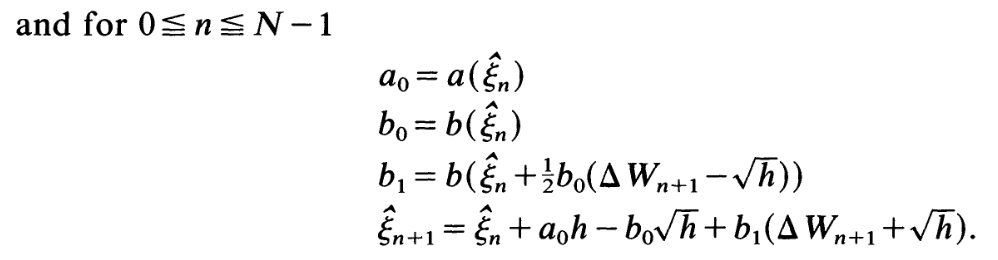


b텀에 해당되는 노이즈의 세기가 $\xi$에 영향을 주지 않는 경우 노의즈에 해당되는 텀은 사라지고 RKHG 방법으로 변하게 된다.

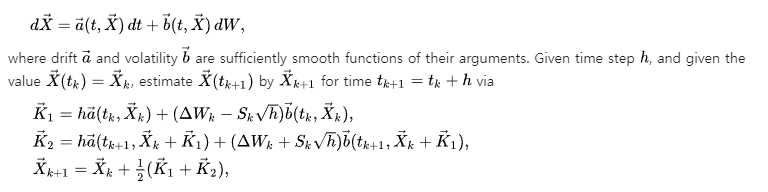  
[Runge–Kutta method (SDE)](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_method_(SDE))

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from tqdm.notebook import tqdm

In [11]:
# @jit(nopython = True)
def RKHG(f,y0,t,D,args=()):
    n = len(t)
    size = len(y0)
    y = np.zeros((n, size))
    y[0] = y0
    h = t[1] - t[0]
    sh = np.sqrt(h)
    for i in range(n - 1):
        S = np.random.choice([-1,1],size=size)
        dW = np.random.normal(0,1,size)*sh
        k1 = h*f(y[i],t[i],*args) + (dW - S*sh)*D
        k2 = h*f(y[i]+k1,t[i]+h,*args) + (dW + S*sh)*D
        y[i+1] = y[i] + 0.5*(k1+k2)
    return y



def RK4(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0

    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1 = f(y[i], t[i], *args)
        k2 = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3 = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4 = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return y

In [12]:
from scipy.special import erfinv
import scipy.stats as scs

def _make_init_theta_(seed,N):
    if type(seed)==str:
        init_theta= np.linspace(-np.pi,np.pi,N,endpoint=False)
    else:
        np.random.seed(seed)
        init_theta = np.random.uniform(-np.pi, np.pi, size=N)
    return init_theta
def Q_Normal(N, mean=0, sigma=1,seed=None):
    """return theta, omega, Kc"""
    init_theta = _make_init_theta_(seed,N)
    init_omega = np.array([mean +sigma*(2**0.5)*erfinv((2*i - N - 1)/(N+1)) for i in range(1,N+1)])
    Kc = 2 / (np.pi * scs.cauchy.pdf(mean, mean, sigma))
    return init_theta, init_omega, Kc




In [13]:
# @jit(nopython=True)
def get_order_parameter(theta,N):
    ''' get theta and return r and theta'''
    rpsi = 1/N*np.sum(np.exp(1j*theta))
    r = np.abs(rpsi)
    psi = np.angle(rpsi)
    return r,psi

# @jit(nopython=True)
def Kuramoto_mf(Theta,t,omega,N,K):
    # print("Case m = 0")
    Theta = Theta.copy()
    theta = Theta[:N]
    r,psi = get_order_parameter(theta,N)
    dtheta = omega + K*r*np.sin(psi - theta)
    Theta[:N] = dtheta
    return Theta


def Kuramoto(Theta,t,omega,N,K):
    # print("Case m = 0")
    Theta = Theta.copy()
    theta = Theta[:N]
    theta_i,theta_j = np.meshgrid(theta,theta,sparse=True)
    dtheta = omega + K/N*np.sum(np.sin(theta_j - theta_i),axis=0)
    Theta[:N] = dtheta
    return Theta

# @jit(nopython=True)
def Kuramoto_mf_AR(Theta,t,omega,N,K,b):
    # print("Case m = 0")
    Theta = Theta.copy()
    theta = Theta[:N]
    r,psi = get_order_parameter(theta,N)
    dtheta = omega + K*r*np.sin(psi - theta) - b*np.sin(theta)
    Theta[:N] = dtheta
    return Theta


def Kuramoto_AR(Theta,t,omega,N,K,b):
    # print("Case m = 0")
    Theta = Theta.copy()
    theta = Theta[:N]
    theta_i,theta_j = np.meshgrid(theta,theta,sparse=True)
    dtheta = omega + K/N*np.sum(np.sin(theta_j - theta_i),axis=0) - b*np.sin(theta)
    Theta[:N] = dtheta
    return Theta



In [14]:
N = 1000

theta_random, omega, Kc = Q_Normal(N, 0, 1, seed=10)
omega = np.sort(omega)-np.mean(omega)
omega = np.ones(N)

In [27]:
K = 1
t_end = 500
dt = 0.1
t = np.arange(0, t_end+dt/2, dt)
D = 0.3
b = 1.01
# sol = RKHG(Kuramoto_mf,theta_random,t,D, args=(omega, N, K))
# sol = RKHG(Kuramoto_mf,theta_random,t,D, args=(omega, N, K))
sol = RKHG(Kuramoto_mf_AR,theta_random,t,D, args=(omega, N, K,b))
# sol = RKHG(Kuramoto_AR,theta_random,t,D, args=(omega, N, K,b))


In [32]:
db = 0.1
Ds = np.arange(0,1+db/2,db)
bs = np.arange(0,1+db/2,db)

Ds = np.linspace(0,1,10)
bs = np.linspace(0,1,10)

In [19]:
th = len(t)//2
D_rij = []
D_sigmaij = []
for D in tqdm(Ds):
    D_rs = []
    D_sigmas = []
    for b in bs:        
        sol = RKHG(Kuramoto_mf_AR,theta_random,t,D, args=(omega, N, K,b))
        theta_s = sol[th:,:N]
        dtheta_s = sol[th:,N:2*N] 
        rabs = np.mean(np.exp(theta_s.T*1j),axis=0)
        # rabs = rabs_[len(t)//2:]
        r = np.abs(rabs)
        sigma_phi = np.mean(rabs)
        sigma = np.abs(sigma_phi)
        psi = np.abs(sigma_phi)
        sigma,np.mean(r)
        D_rs.append(r)
        D_sigmas.append(sigma)
    D_rij.append(D_rs)
    D_sigmaij.append(D_sigmas)

  0%|          | 0/10 [00:00<?, ?it/s]

In [20]:
D_rij = np.array(D_rij)
D_sigmaij = np.array(D_sigmaij)

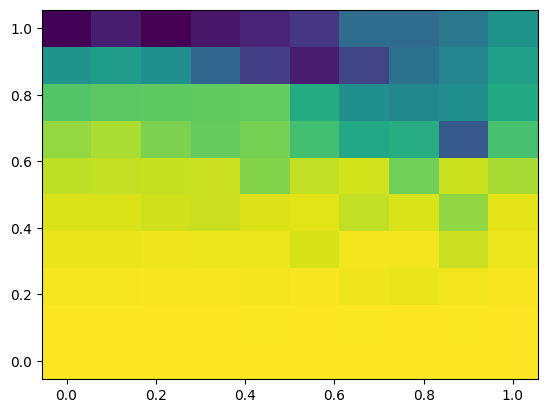

In [26]:
plt.pcolormesh(Ds,bs,D_rij[:,:,-1])

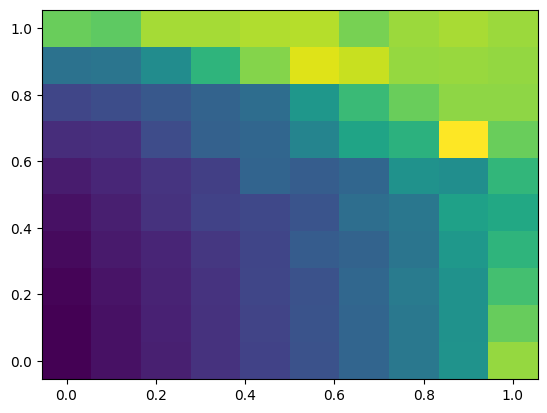

In [44]:
plt.pcolormesh(Ds,bs,D_sigmaij-D_rij[:,:,-1])
# plt.imshow(D_sigmaij.T)
# plt.axes().set_aspect('equal')
# plt.pcolormesh(Ds,bs,D_sigmaij.T)


In [ ]:
theta_s = sol[:,:N]
dtheta_s = sol[:,N:2*N] 
rabs_ = np.mean(np.exp(theta_s.T*1j),axis=0)
rabs = rabs_[len(t)//2:]
r = np.abs(rabs)
sigma_phi = np.mean(rabs)
sigma = np.abs(sigma_phi)
psi = np.abs(sigma_phi)
sigma,np.mean(r)

In [50]:
D_r_meanij = np.mean(D_rij,axis=2)

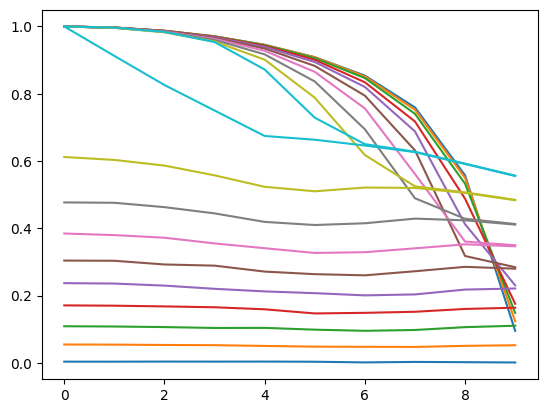

In [52]:
plt.plot(D_r_meanij[:,:])
plt.plot(D_sigmaij[:,:])
# plt.plot(D_rij[:,5,-1])

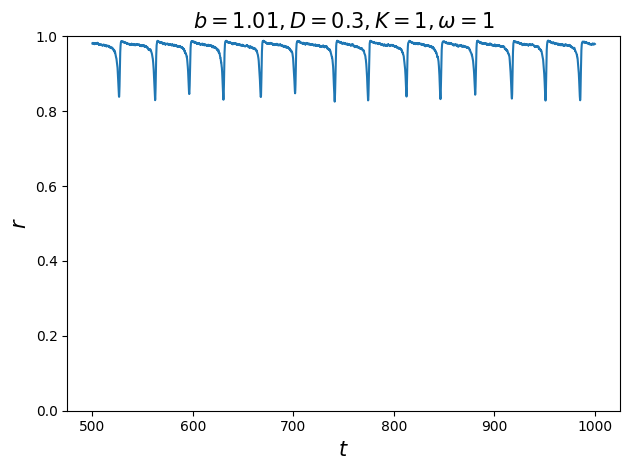

In [190]:
plt.plot(t[len(t)//2:],r)
plt.xlabel('$t$',fontsize=15)
plt.ylabel('$r$',fontsize=15)
plt.title(rf'$b={b},D={D},K={K},\omega=1$',fontsize=15)
plt.ylim(0.0,1)
plt.tight_layout()

In [191]:
h,b_ = np.histogram(np.sin(theta_s[len(t)//2,:]),bins=100)
hs = []
for i in range(2000):
    h,_ = np.histogram(np.sin(theta_s[len(t)//2+i,:]),bins=b_)
    hs.append(h)
hs = np.array(hs)
h

array([ 4,  8,  5,  5,  3,  7,  6,  6,  6,  1,  7,  8,  6,  5,  5,  6, 11,
        7,  9,  4,  5,  4,  5,  2,  5,  4,  6,  6,  5,  7,  6,  5,  8,  8,
        7,  7, 12,  7,  5,  7,  7,  5, 10,  7,  4, 10,  6, 13,  6,  9,  7,
        7,  6, 10,  8,  7,  3,  9,  7,  9,  8,  9,  6,  7,  8,  5,  8,  9,
        5,  9,  8, 10, 10,  6,  5,  3,  5,  4, 10,  9,  8,  6,  4,  2,  4,
        5,  6,  3,  7, 10,  4,  7,  5,  3,  1,  2,  6,  1,  5,  6])

In [192]:
dtheta_s = np.diff(theta_s/dt,axis=0)

In [193]:
dtheta_s = np.diff(theta_s,axis=1)
sum_time = 10
dtheta_c = np.cumsum(dtheta_s[:], axis=0)
avg_dtheta = (dtheta_c[sum_time:]-dtheta_c[:-sum_time])/sum_time
diff_avg_dtheta = np.diff(avg_dtheta, axis=1)

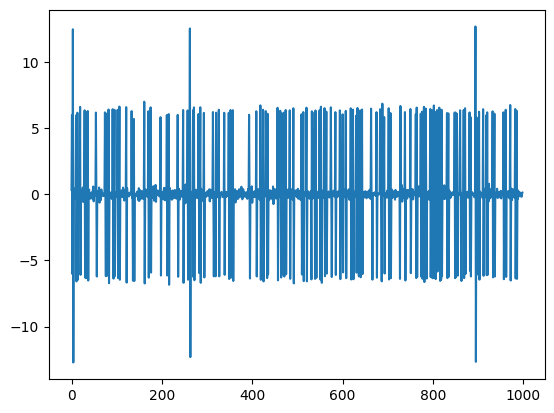

In [194]:
plt.plot(avg_dtheta[-1])

In [195]:
np.mean(avg_dtheta[-1])

0.0001789671814094307

In [196]:
avg_dtheta.shape

(9991, 999)

In [197]:
b_theta = np.arcsin(b_)

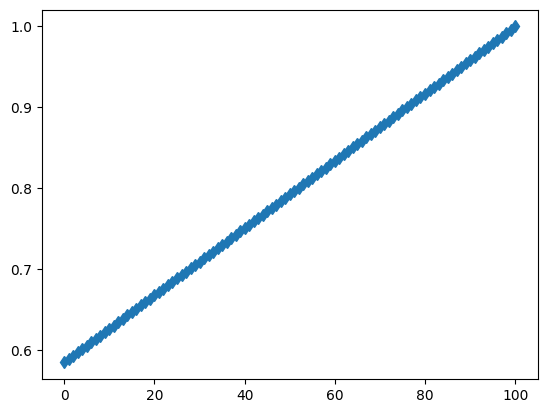

In [198]:
plt.plot(b_,'d')

In [199]:
A = (theta_s+np.pi)%(2*np.pi)-np.pi

In [200]:
h,b_ = np.histogram(np.linspace(-np.pi,np.pi),bins=200)
# h,b_ = np.histogram(A[len(t)//2,:],bins=100)
hs = []
for i in range(2000):
    h,_ = np.histogram(A[len(t)//2+i,:],bins=b_)
    hs.append(h)
hs = np.array(hs)
# b_theta = np.arcsin(b_)


In [201]:
b_theta = b_

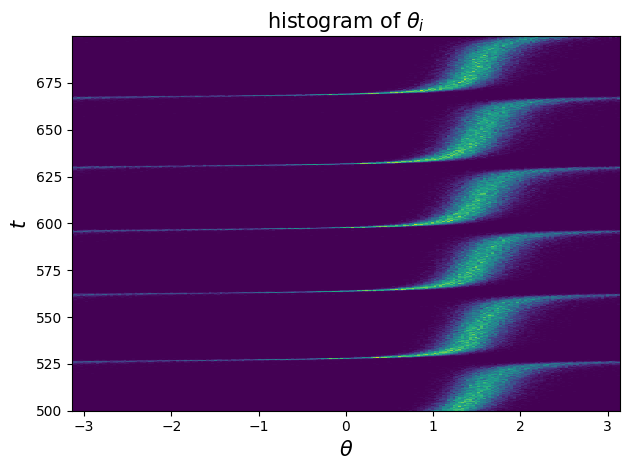

In [202]:
plt.pcolormesh(b_theta,t[len(t)//2:len(t)//2+2000],hs[1:])
plt.gca().set_aspect('auto')
plt.ylabel(r'$t$',fontsize=15)
plt.xlabel(r'$\theta$',fontsize=15)
plt.title(r'histogram of $\theta_i$',fontsize=15)
plt.xlim(-np.pi,np.pi)
plt.tight_layout()

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,
          1.,   1.,   1.,   0.,   0.,   1.,   0.,   3.,   1.,   3.,   4.,
          3.,   2.,   3.,   2.,   2.,   4.,   3.,   2.,   3.,   4.,   4.,
          2.,   7.,   8.,   9.,  18.,  10.,   3.,  13.,  22.,  16.,  16.,
         20.,  19.,  24.,  21.,  27.,  19.,  29.,  27.,  32.,  27.,  24.,
         35.,  31.,  40.,  28.,  30.,  36.,  38.,  46.,  50.,  52.,  56.,
        112.]),
 array([0.9275491 , 0.92827361, 0.92899812, 0.92972262, 0.93044713,
        0.93117164, 0.93189615, 0.93262066, 0.93334517, 0.93406967,
        0.93479418, 0.93551869, 0.9362432 , 0.93696771, 0.93769222,
        0.93841672, 0.93914123, 0.93986574, 0.94059025, 0.94131476,
        0.94203927, 0.94276377, 0.94348828, 0.

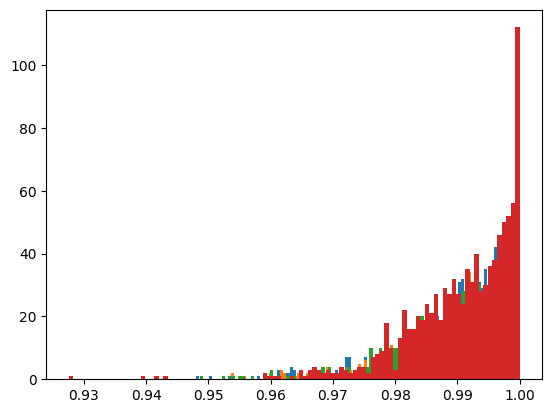

In [132]:

plt.hist(np.sin(theta_s[len(t)//2,:]),bins=100)
plt.hist(np.sin(theta_s[len(t)//2+10,:]),bins=100)
plt.hist(np.sin(theta_s[len(t)//2+20,:]),bins=100)
plt.hist(np.sin(theta_s[len(t)//2+30,:]),bins=100)